0 - Libraries

In [17]:
import re
import os
import glob
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import importlib
import requests
from tqdm import tqdm
import datetime
import pytz
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [28]:
import pvlib
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib import pvsystem

In [23]:
import av_potential_utils as av
importlib.reload(av)

<module 'av_potential_utils' from 'c:\\Users\\David Jung\\CSET_AV_Chile\\CSET_AV_Chile\\av_potential_utils.py'>

In [3]:
# Configuration
crs_i = 4326

1 - Import of prepared geodata (see AV_Chile_BBDD notebook)

In [5]:
gdf_cl = gpd.read_file("processed\\gdf_cl_rm.shp")          # Region RM borders
gdf_agri = gpd.read_file("processed\\gdf_agri_rm.shp")      # Agricultural ground in RM
gdf_des = gpd.read_file("processed\\gdf_desert_rm.shp")     # Data on desertification for comunes in RM
gdf_preci = gpd.read_file("processed\\gdf_preci_rm.shp")    # Data on precipitation for weather stations in RM

In [6]:
# Functions for handeling of geodataframes
def get_sirgas_crs_point(point):
    # Define the SIRGAS-Chile UTM zones
    crs_19S = 'EPSG:32719'  # WGS 84 / UTM zone 19S
    crs_18S = 'EPSG:32718'  # WGS 84 / UTM zone 18S
    crs_17S = 'EPSG:32717'  # WGS 84 / UTM zone 17S
    
    # Function to determine the appropriate CRS based on longitude
    lon = point.x
    if -72 <= lon < -66:
        return crs_19S
    elif -78 <= lon < -72:
        return crs_18S
    elif -84 <= lon < -78:
        return crs_17S
    else:
        raise ValueError("Longitude out of range for defined SIRGAS-Chile UTM zones.")

def get_sirgas_crs_polygon(gdf_polygon):
    shapefile_4326 = gdf_cl.to_crs(epsg = 4326)
    max_point = Point(shapefile_4326.bounds.max()[["maxx","maxy"]])
    # Create a Shapely Point and then a GeoDataFrame with the point, specifying the CRS as EPSG:4326
    crs_max = get_sirgas_crs_point(max_point)

    min_point = Point(shapefile_4326.bounds.min()[["minx","miny"]])
    crs_min = get_sirgas_crs_point(min_point)
    if crs_max == crs_min:
        crs = crs_max
    else:
        crs = 'EPSG:32719'       # Prefere CRS of central zone
    return crs

def plot_gdf(gdf,gdf_boundaries,column=None, color='Greens', markersize=None):
    # Plot shapefile of Chilean region and dataset
    if column is None:
        if markersize is None:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10))
        else:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), markersize=gdf[markersize]/100000)
    else:
        if markersize is None:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), column=column,cmap=color, legend=True) 
        else:
            ax = gdf.to_crs(crs_i).plot(figsize=(10, 10), column=column,cmap=color, markersize=gdf[markersize]/100000, legend=True) 
    gdf_boundaries.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

    if column is not None:
        plt.title(column +" in dataset")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

The dataset contains 20 points


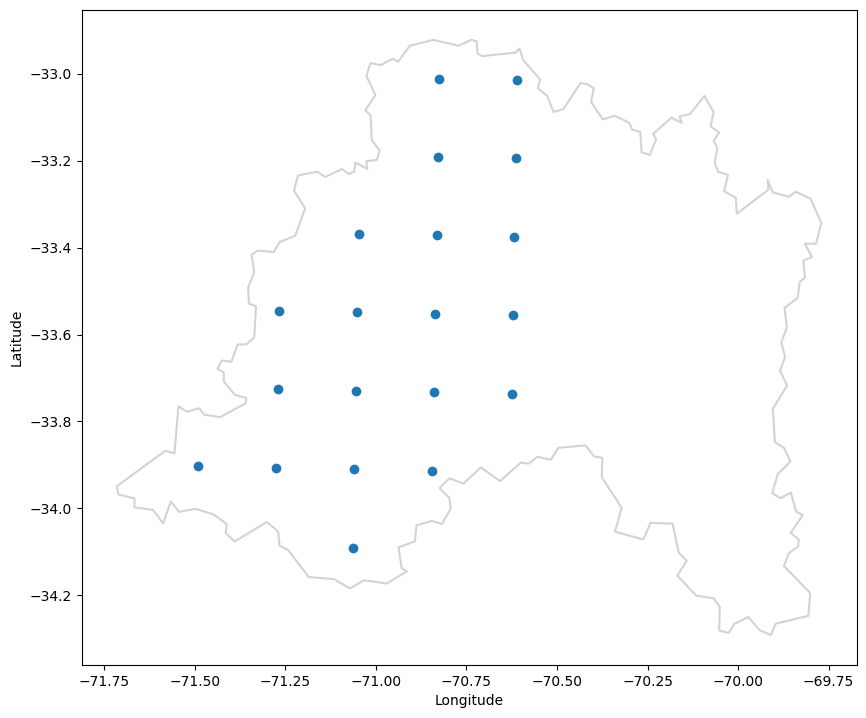

In [7]:
# Function for creating the point dataset 
# Is filtered to only contain points that are close to agricultural land
def create_working_gdf(shapefile_agri,shapefile_pol,distance_km):
    # Detect correct CRS and convert
    crs = get_sirgas_crs_polygon(shapefile_agri.to_crs(epsg = 4326))
    shapefile_agri = shapefile_agri.to_crs(crs)

    # Extract max and min points 
    maxx, maxy = shapefile_agri.bounds.max()[["maxx","maxy"]]
    minx, miny = shapefile_agri.bounds.min()[["minx","miny"]]
    delta = distance_km * 1000                              # Get distance between points in meter

    # Create a list to store the points
    points = []

    # Create points
    for x in range(0,int(abs((maxx - minx)/delta))+1):
        for y in range(0,int(abs((maxy - miny)/delta))+1):
            # Calculate "next" point
            next_y = miny + (y * delta)
            next_x= minx + (x * delta)
            # Create the point and add to list
            point = Point(next_x, next_y)
            points.append(point)

    # Create a GeoDataFrame from the list of points and filter for points inside the shapefile
    point_dataset = gpd.GeoDataFrame(geometry=points, crs = crs)

    # Filter for proximity to shapefile_agri areas
    gdf_raw = gpd.sjoin_nearest(point_dataset, shapefile_agri, how='inner', max_distance=delta/math.sqrt(2), lsuffix="l", rsuffix='r', distance_col="dist")
    
    # Filter for borders of shapefile_pol (political borders)
    shapefile_pol["x"] = shapefile_pol.index
    gdf = gpd.sjoin(left_df=gdf_raw , right_df=shapefile_pol[["x","geometry"]])
    
    # get Lat and Long in CRS 4326
    gdf["lat_4326"] = gdf.to_crs(epsg = 4326).geometry.y.round(2)
    gdf["long_4326"] = gdf.to_crs(epsg = 4326).geometry.x.round(2)
    
    gdf = gdf.reset_index(drop=True)
    gdf["index"] = gdf.index
    gdf = gdf[['index', "lat_4326", "long_4326",'region','geometry']] 
    print("The dataset contains "+str(len(gdf))+" points")
    return gdf

# Apply function with user-defined distance between points
distance_km = 20
gdf = create_working_gdf(shapefile_agri=gdf_agri,shapefile_pol=gdf_cl,distance_km=distance_km)
plot_gdf(gdf,gdf_cl)

In [8]:
def discretize_input_in_gdf(gdf, gdf_input, column):

    # Set CRS
    crs = get_sirgas_crs_polygon(gdf_des)
    gdf = gdf.to_crs(crs)
    gdf_input = gdf_input.to_crs(crs)

    if column in gdf.columns:
        gdf = gdf.drop(columns=[column])

    # Find nearest point and store index in gdf_berries
    gdf = gpd.sjoin_nearest(gdf, gdf_input[[column, "geometry"]], rsuffix = "sjoin")
    columnsd = gdf.filter(like='sjoin').columns
    gdf = gdf.drop(columns=columnsd)
    return gdf

# Get information and store in gdf
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_des, column="desert")
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_preci, column="preci_mm")
gdf = discretize_input_in_gdf(gdf, gdf_input=gdf_preci, column="preci_a_mm")

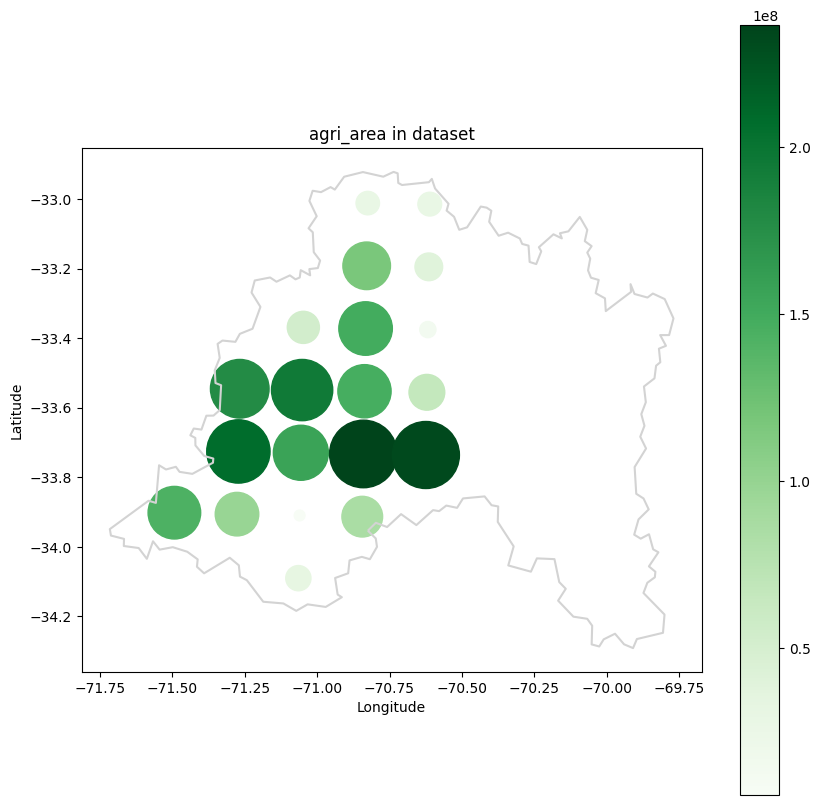

In [9]:
# Agricultural Areas discretization 

# input
column = "agri_area"
gdf_input = gdf_agri.copy()

# Set CRS
crs = get_sirgas_crs_polygon(gdf_des)
gdf = gdf.to_crs(crs)
gdf_input = gdf_input.to_crs(crs)

# Prepare gdfs
gdf_input = gdf_input.reset_index(drop=True)
gdf_input["ref"] = gdf_input.index
gdf_input[column] = gdf_input.geometry.area
if column in gdf.columns:
    gdf = gdf.drop(column, axis=1)

# Find nearest point and store index with suffix "points"
gdf_input = gpd.sjoin_nearest(gdf_input,gdf, rsuffix="points")
gdf_input = gdf_input.drop_duplicates(subset='ref', keep="first")

# Store information in gdf
for i in gdf.index:
    gdf.loc[i,column] = float(gdf_input[gdf_input["index_points"] == i][column].sum())

# Could also extract type of agriculture and land class
#land_class_unique = gdf_input["land_class"].unique()
#agri_type_unique = gdf_input["agri_type"].unique()
#for agri_type in agri_type_unique:
#    for land_class in land_class_unique:
#        for i in gdf.index:
#            gdf.loc[i,agri_type+"_"+land_class+"_area"] = float(gdf_input[(gdf_input["index_points"] == i) & (gdf_input["agri_type"] == agri_type) & (gdf_input["land_class"] == land_class)]["area"].sum())

plot_gdf(gdf,gdf_cl,column=column, color='Greens', markersize=column)

2 - Climate data TMYs

In [31]:
# Load TMY from local file
def load_TMY(f):
    tmy = pd.read_csv(f, encoding='latin-1')
    tmy["time"] = pd.date_range(start = "2022-01-01 00:00", end="2022-12-31 23:00", freq="h")
    tmy.loc[tmy["info"] == "lat_4326","info_values"] = float(tmy.loc[tmy["info"] == "lat_4326","info_values"])
    tmy.loc[tmy["info"] == "long_4326","info_values"] = float(tmy.loc[tmy["info"] == "long_4326","info_values"])
    tmy.loc[tmy["info"] == "altitude","info_values"] = float(tmy.loc[tmy["info"] == "altitude","info_values"])
    return tmy

# update information in gdf 
def update_gdf_from_TMY(gdf,cord,tmy):
    lat_4326 = float(cord[0][0])
    long_4326 = float(cord[0][1])
    gdf.loc[((gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)), "altitude"] = tmy.loc[tmy['info'] == "altitude","info_values"].iloc[0]
    gdf.loc[((gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)), "PVGIS_dl"] = tmy.loc[tmy['info'] == "PVGIS_dl","info_values"].iloc[0]
    gdf.loc[((gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)), "GHI_KWh/a"] = tmy.ghi.sum()/1000

    
    return gdf

# get TMY from PVGIS
def get_TMY(lat_4326, long_4326, tz='America/Santiago',directory="data\\PVGIS_TMY\\"):
    lat_4326 = round(lat_4326,2)
    long_4326 = round(long_4326,2)

    try: 
        # API request            
        data_pvgis  = pvlib.iotools.get_pvgis_tmy(lat_4326, long_4326, outputformat='json', usehorizon=True, userhorizon=None, startyear=None, endyear=None, url='https://re.jrc.ec.europa.eu/api/v5_2/', map_variables=None, timeout=30)
        
        # Get altitude and tmy data
        tmy_pvg_r = data_pvgis[0]
        altitude = data_pvgis[2].get("location").get("elevation")

        # adapt to local timezone
        timezone = pytz.timezone(tz)
        dt = datetime.datetime.utcnow()
        offset_hours = timezone.utcoffset(dt).seconds / 3600.0
        if offset_hours > 12:
            offset_hours = offset_hours - 24
        if offset_hours < 0:
            offset_hours = int(-offset_hours)
            # Extract the first rows according to the time offset
            first_rows = tmy_pvg_r.head(offset_hours)
            tmy_pvg_r  = tmy_pvg_r.drop(tmy_pvg_r.index[:offset_hours])
            # Concatenate the modified DataFrame and the first three rows
            tmy_pvg = pd.concat([tmy_pvg_r, first_rows])   
        else:
            print("TMY download only for South America")
        tmy_pvg["time"] = pd.date_range(start = "2022-01-01 00:00", end="2022-12-31 23:00", freq="h", tz=tz)
        tmy_pvg.index = tmy_pvg["time"]

        # Information on PVGIS Download
        if (tmy_pvg["G(h)"].sum() < 1):
            download_info = "missing solar data"
        elif (tmy_pvg["WS10m"].sum() < 1) | (tmy_pvg["T2m"].sum() < 1):
            download_info = "missing climate data"
        else:
            download_info = "ok"

        # process tmy data: Rename for pvlib
        cols_to_use = ["time", "T2m", "G(h)", "Gb(n)", "Gd(h)", "IR(h)", "WS10m", "RH", "SP"] 
        pvlib_column_names = ["time", "temp_air", "ghi", "dni", "dhi", "lwr_u", "wind_speed", "rh", "sp" ] 
        tmy_pvg = tmy_pvg[cols_to_use]
        tmy_pvg.columns = pvlib_column_names
        

        location = Location(lat_4326, long_4326, tz, altitude)
        # Get solar azimuth and zenith to store in tmy
        solar_position = location.get_solarposition(times=tmy_pvg.index)
        tmy_pvg["azimuth"] = solar_position["azimuth"] 
        tmy_pvg["zenith"] = solar_position["zenith"] 
        tmy_pvg["apparent_zenith"] = solar_position["apparent_zenith"] 
        tmy_pvg = tmy_pvg.reset_index(drop=True)
        
        # Store meta data
        tmy_pvg.loc[0, "info"] = "lat_4326"
        tmy_pvg.loc[1, "info"] = "long_4326"
        tmy_pvg.loc[2, "info"] = "altitude"
        tmy_pvg.loc[3, "info"] = "PVGIS_dl"

        tmy_pvg.loc[0, "info_values"] = lat_4326
        tmy_pvg.loc[1, "info_values"] = long_4326
        tmy_pvg.loc[2, "info_values"] = altitude
        tmy_pvg.loc[3, "info_values"] = download_info

        # Save as csv
        outFileName = "TMY_" + str(lat_4326)+"_"+str(long_4326)
        tmy_pvg.to_csv(directory+outFileName+".csv", sep=',',encoding='latin-1', index=False)


    except requests.HTTPError as err:
        tmy_pvg = None
        altitude = None
        download_info = err

    return tmy_pvg, altitude, download_info

# use gdf to realize automized download of TMYS from 
def get_TMYs_from_gdf(gdf, tz='America/Santiago', directory="data\\PVGIS_TMY\\", tmy_all=None):
    
    crs_gdf = gdf.crs
    gdf = gdf.to_crs(epsg = 4326)
    gdf["lat_4326"] = gdf.geometry.y.round(2)
    gdf["long_4326"] = gdf.geometry.x.round(2)
    
    for i in tqdm(gdf.index):
        if gdf.loc[i,"PVGIS_dl"] != "ok": 
            lat_4326 = gdf.loc[i,"lat_4326"]
            long_4326 = gdf.loc[i,"long_4326"]
            tmy_pvg, altitude, download_info = get_TMY(lat_4326, long_4326, tz=tz)
            if download_info == "ok":
                gdf.loc[i,"altitude"] = altitude
                gdf.loc[i,"PVGIS_dl"] = download_info
                gdf.loc[i,"GHI_KWh/a"] = tmy_pvg["ghi"].sum()/1000

            else:
                gdf.loc[i,"GHI_KWh/a"] = None
                gdf.loc[i,"altitude"] = altitude
                gdf.loc[i,"PVGIS_dl"] = download_info

    gdf = gdf.to_crs(crs_gdf)

    print("PVGIS Download finished: "+ str(len(gdf[gdf['PVGIS_dl'] != "ok"]))+ " locations without (complete) TMY data")
    gdf.to_csv("data_used_for_PVGIS_dl.csv", sep=',',encoding='latin-1', index=False)
    
    return gdf

# Temporary function for reordering the gdf
def reorder_columns(df):
    # Columns to move after 'long_4326'
    cols_to_move = ['altitude', 'PVGIS_dl', 'GHI_KWh/a']
    # Column to move to the end
    col_to_move_end = 'geometry'

    if all(col in gdf.columns for col in cols_to_move) and col_to_move_end in gdf.columns:

        # Find the position of 'long_4326'
        pos = df.columns.get_loc('long_4326')

        # Create a list of columns in the new order
        cols = df.columns.tolist()
        for col in cols_to_move:
            cols.remove(col)
        cols.remove(col_to_move_end)

        # Insert the 'cols_to_move' columns after 'long_4326'
        new_order = cols[:pos+1] + cols_to_move + cols[pos+1:]

        # Append the 'col_to_move_end' column at the end
        new_order.append(col_to_move_end)

        # Reorder the DataFrame
        df = df[new_order]
    else: 
        print("please check gdf, not all columns found")
    return df

In [33]:
# Get all coordinates from gdf
coordinates_list = list(zip(gdf['lat_4326'].round(2).astype(str), gdf['long_4326'].round(2).astype(str)))
gdf["PVGIS_dl"] = np.nan
gdf["altitude"] = np.nan
gdf["GHI_KWh/a"] = np.nan

# Get info on available csv files
directory_TMYs="data\\PVGIS_TMY\\"
path = os.getcwd()+"\\"+directory_TMYs
tmy_files = glob.glob(path + "\*.csv")

# Pattern of file names to extract coordinates
pattern = r'([-+]?\d+\.\d+)_([-+]?\d+\.\d+)\.csv'

# loop over the list of csv files, load infr from matched TMYs and delete not-matched TMYs
for f in tqdm(tmy_files):
    # Using re.findall() to extract the coordinates
    cord = re.findall(pattern, f)
    try:
        index = coordinates_list.index(cord[0])
        tmy = load_TMY(f)
        gdf = update_gdf_from_TMY(gdf,cord,tmy)
    except:
        os.remove(f)

gdf = get_TMYs_from_gdf(gdf, tz='America/Santiago', directory="data\\PVGIS_TMY\\", tmy_all=None)
gdf = reorder_columns(gdf)

0it [00:00, ?it/s]
100%|██████████| 20/20 [01:41<00:00,  5.05s/it]

PVGIS Download finished: 0 locations without (complete) TMY data


3 - Technical and Economical modelling

In [34]:
## TECHNICAL PARAMETERS
# Fix parameters for all cases
albedo = 0.2
generation_target = 500000 # kWh / year

# PV Module Data
length_module = 2.384 # m
width_module = 1.303 # m
cap_module = 0.64 # kWp 
PV_W_per_m2 = cap_module * 1000 / (length_module * width_module)

# (A)PV Configurations
input = pd.DataFrame({"parameter": ["tracking", "pvrow_azimuth", "pvrow_tilt", "pvrow_distance","pvrow_width", "pvrow_height", "bifaciality"]}).set_index("parameter")
#input["FV Convencional"] = [False, 0, 15, 5, 2*width_module, 1.5, 0.9]
input["AV Elevado Fijo"] = [False, 0, 10, 7.7, 2*width_module, 3, 0.9]
#input["AV Elevado Seguimiento"] = [True, 90, 50, 7.7, 2*width_module, 3, 0.9]
#input["AV vertical"] = [False, 90, 90, 5, 2*width_module, 1.5, 0.9]

# Calculation of GCR and Density

for case in input.columns:
    input.loc["GCR", case] = round(input.loc["pvrow_width", case] / input.loc["pvrow_distance", case],3)
    if input.loc["tracking",case] == True:
        real_pvwidth = input.loc["pvrow_width",case]
    else:
        real_pvwidth = input.loc["pvrow_width",case] * math.cos(math.radians(input.loc["pvrow_tilt",case]))
    input.loc["GCR_real",case] = round(real_pvwidth / input.loc["pvrow_distance",case],3)
input.loc["Density_kWp_ha"] =  input.loc["GCR"] * PV_W_per_m2 *10

# Get cases based on input columns
APV_types = input.columns.values

# Show input table
input

,AV Elevado Fijo
parameter,
tracking,False
pvrow_azimuth,0
pvrow_tilt,10
pvrow_distance,7.7
pvrow_width,2.606
pvrow_height,3
bifaciality,0.9
GCR,0.338
GCR_real,0.333


In [35]:
# Get info on available csv files
directory_TMYs="data\\PVGIS_TMY\\"
path = os.getcwd()+"\\"+directory_TMYs
tmy_files = glob.glob(path + "\*.csv")

# Iteration over cases for py yield simulation with case specific inputs
for type in APV_types:
    # Inputs for PV simulation
    track =         input.loc["tracking",case] 
    pvrow_azimuth = input.loc["pvrow_azimuth",case] 
    pvrow_tilt =    input.loc["pvrow_tilt",case] 
    pvrow_height =  input.loc["pvrow_height",case] 
    pvrow_width =   input.loc["pvrow_width",case] 
    pvrow_pitch =   input.loc["pvrow_distance",case] 
    bifaciality =   input.loc["bifaciality",case] 
    n_pvrows = 3

    # Run simulation for all entries in gdf with local TMYs
    for i in tqdm(gdf.index):
        # set index
        lat_4326 = gdf.loc[i,"lat_4326"]
        long_4326= gdf.loc[i,"long_4326"]
        cord = str(lat_4326)+"_"+str(long_4326)
        tmy_path = next((file for file in tmy_files if cord in file), None)
        tmy = load_TMY(tmy_path)
        tmy[type+"_ac_W"] = av.calc_PV(tmy, albedo, track, pvrow_azimuth, pvrow_tilt, n_pvrows, pvrow_width, pvrow_pitch, pvrow_height, bifaciality=0.2, losses= None)
        gdf.loc[((gdf["long_4326"] == long_4326) & (gdf["lat_4326"] == lat_4326)), type+"_ac_kWh_a"] = tmy[type+"_ac_W"].sum()/1000
        #tmy.to_csv(tmy_path, sep=',',encoding='latin-1', index=False)

100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


In [36]:
## Evapotranspiation
# Run simulation for all entries in gdf with local TMYs
for i in tqdm(gdf.index):
    lat_4326 = gdf.loc[i,"lat_4326"]
    long_4326= gdf.loc[i,"long_4326"]
    cord = str(lat_4326)+"_"+str(long_4326)
    tmy_path = next((file for file in tmy_files if cord in file), None)
    tmy = load_TMY(tmy_path)
    ele = gdf.loc[i,"altitude"]
    tmy["ET_0_mm_ref"] = av.calc_ET(tmy, lat_4326, ele, apv_shading=0)
    gdf.loc[i, "ET_0_mm"] = tmy["ET_0_mm_ref"].sum()
    for type in APV_types:
    # Inputs for PV simulation
        gcr = input.loc["GCR_real",case] 
        tmy["ET_0_mm_"+type] = av.calc_ET(tmy, lat_4326, ele, apv_shading=gcr)
        gdf.loc[i, "ET_0_mm_"+type] = tmy["ET_0_mm_"+type].sum()
    tmy.reset_index(drop=True).to_csv(tmy_path, sep=',',encoding='latin-1', index=True)

100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


In [37]:
# ECONOMIC PARAMETERS
# Tecnical Parameters
degre = 0.005                   # Degredatio of PV system [%]

# financial parameters
wacc = 0.1125                     # Weighted average cost of capital
inflation = 0.038                # Inflation
tax = 0.316                      # Corperate tax rate 
N = 25                          # Lifetime of AV system

# GM PV	AV tracking	AV fix	AV vertical
input.loc["capex"] = [923]
input.loc["opex"] = [18]

kWp = 1
for i in tqdm(gdf.index):
    E_G = gdf.loc[i,type+"_ac_kWh_a"]
    CAPEX = input.loc["capex",case] *kWp                    # Specific Capital Expenditure in [USD per kWp]
    OPEX = input.loc["opex",case] * kWp
    gdf.loc[i,"LCOE"] = av.calc_LCOE(E_G=E_G, CAPEX=CAPEX, OPEX=OPEX, wacc=wacc, degre = degre, inflation = inflation, N = N) * 1000

gdf["ET_save_mm"] = gdf["ET_0_mm"] - gdf["ET_0_mm_AV Elevado Fijo"]


100%|██████████| 20/20 [00:00<00:00, 99.22it/s]


In [38]:
gdf

,index,lat_4326,long_4326,altitude,PVGIS_dl,GHI_KWh/a,region,desert,preci_mm,preci_a_mm,agri_area,geometry,AV Elevado Fijo_ac_kWh_a,ET_0_mm,ET_0_mm_AV Elevado Fijo,LCOE,ET_save_mm
0,0,-33.90,-71.49,315.0,ok,1971.70735,Region Metropolitana de Santiago,Grave,454.3,-3.2,1.433710e+08,POINT (269516.334 6245944.838),1450.589071,1344.308473,1137.547239,97.961065,206.761233
1,1,-33.91,-71.28,583.0,ok,2056.70213,Region Metropolitana de Santiago,Leve,430.4,1.6,9.827240e+07,POINT (289516.334 6245944.838),1485.393550,1348.311507,1114.472575,95.665725,233.838932
6,6,-33.73,-71.06,288.0,ok,2028.52290,Region Metropolitana de Santiago,S/I,430.4,1.6,1.570028e+08,POINT (309516.334 6265944.838),1429.232515,1257.559936,1023.593175,99.424866,233.966761
2,2,-33.73,-71.27,124.0,ok,2053.09519,Region Metropolitana de Santiago,Leve,387.4,-1.7,2.077199e+08,POINT (289516.334 6265944.838),1479.588201,1275.826989,1050.184469,96.041081,225.642520
3,3,-33.55,-71.27,265.0,ok,2075.08069,Region Metropolitana de Santiago,Leve,375.6,-4.8,1.781258e+08,POINT (289516.334 6285944.838),1488.159846,1228.039098,1000.703860,95.487895,227.335237
7,7,-33.55,-71.05,639.0,ok,1871.28033,Region Metropolitana de Santiago,Leve,327.5,-4.4,1.944763e+08,POINT (309516.334 6285944.838),1417.984691,1223.207922,1002.257712,100.213530,220.950211
8,8,-33.37,-71.05,658.0,ok,2083.92847,Region Metropolitana de Santiago,Leve,327.5,-4.4,5.346659e+07,POINT (309516.334 6305944.838),1488.684315,1240.334872,1000.578270,95.454254,239.756602
4,4,-34.09,-71.06,1098.0,ok,1924.82472,Region Metropolitana de Santiago,Grave,479.5,-1.0,3.296732e+07,POINT (309516.334 6225944.838),1404.300942,1183.231877,949.854910,101.190027,233.376967
5,5,-33.91,-71.06,954.0,ok,1933.61006,Region Metropolitana de Santiago,Grave,479.5,-1.0,5.982202e+06,POINT (309516.334 6245944.838),1376.747784,1213.693738,986.670704,103.215166,227.023034
9,9,-33.91,-70.84,968.0,ok,1936.92766,Region Metropolitana de Santiago,Leve,377.1,-5.4,8.586501e+07,POINT (329516.334 6245944.838),1347.064621,1160.321985,943.225462,105.489558,217.096523


4 - MCDM

In [39]:
def get_fuzzy(column,min_or_max):
    column = column.astype(float)
    fuzzy = column.copy()
    min = column.min()
    max = column.max()
    for i in column.index:
        if min_or_max == "max":
            fuzzy[i] = 1 / (max-min) * (column[i]-min)
        else:
            fuzzy[i] = 1- (1 / (max-min) * (column[i]-min))
    return fuzzy

In [44]:
# Get fuzzy values for serveral columns
gdf["PV_fuzzy"] = get_fuzzy(gdf["AV Elevado Fijo_ac_kWh_a"],"max")
gdf["LCOE_fuzzy"] = get_fuzzy(gdf["LCOE"],"min")
gdf["ET_fuzzy"] = get_fuzzy(gdf["ET_save_mm"],"max")
gdf["Preci_fuzzy"] = get_fuzzy(gdf["preci_a_mm"],"min")
gdf["desert_fuzzy"] = np.where(gdf["desert"] == "Grave",1,np.where(gdf["desert"] == "Moderada",0.6,0.3))

# Calculate traditional MCDM
gdf["MCDM"] = 0.2 * gdf["PV_fuzzy"] + 0.1 * gdf["LCOE_fuzzy"] + 0.3 * gdf["ET_fuzzy"] + 0.3* gdf["Preci_fuzzy"] + 0.1 * gdf["desert_fuzzy"]

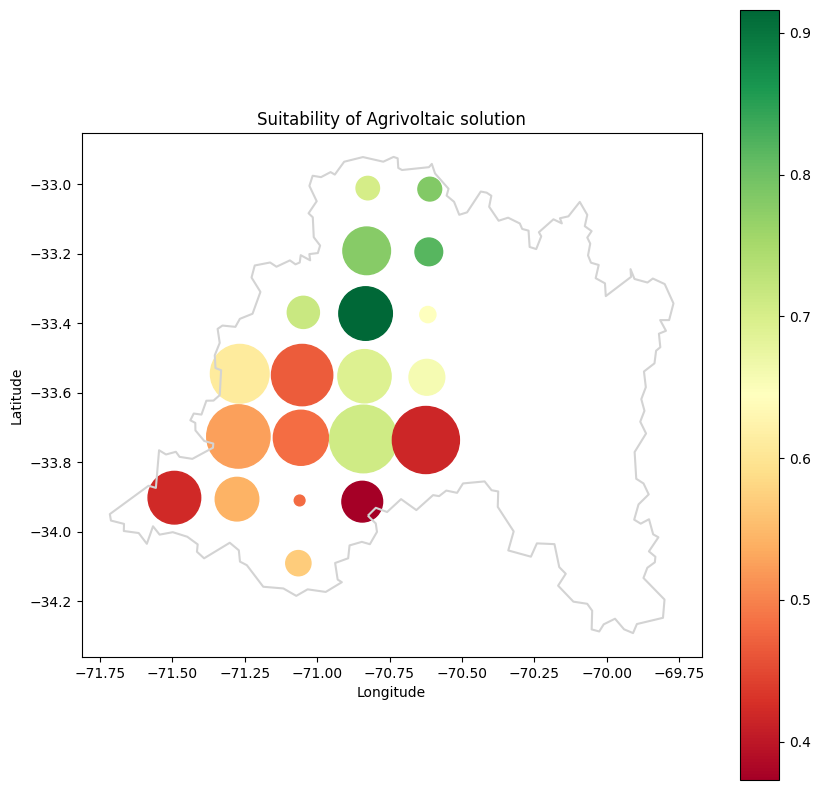

In [45]:
# Plot shapefile of Chilean regions 
ax = gdf.to_crs(crs_i).plot(figsize=(10, 10),markersize=gdf['agri_area']/100000, column="MCDM", cmap='RdYlGn', legend=True)
gdf_cl.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Suitability of Agrivoltaic solution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

4.1 - Context specific MCDM

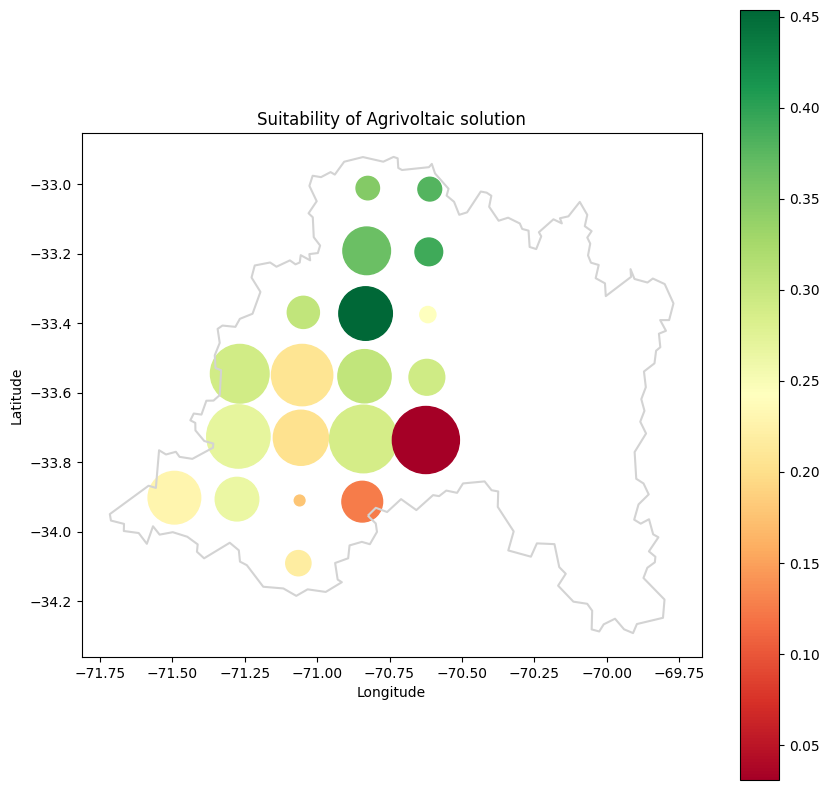

In [46]:
# Calculate context specific MCDM -> Evapotranspiration potential is weighted by desertification state and precipitation anomaly
gdf["MCDM_new"] = 0.2 * gdf["PV_fuzzy"] + 0.1 * gdf["LCOE_fuzzy"] + 0.3 * (gdf["ET_fuzzy"] * gdf["Preci_fuzzy"] * gdf["desert_fuzzy"])

# Plot shapefile of Chilean regions 
ax = gdf.to_crs(crs_i).plot(figsize=(10, 10),markersize=gdf['agri_area']/100000, column="MCDM_new", cmap='RdYlGn', legend=True)
gdf_cl.to_crs(crs_i).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Suitability of Agrivoltaic solution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

BACKUP

In [47]:
"""
def calc_GCR(tmy, albedo, AV_designs, design, pvrow_azimuth, pvrow_tilt, n_pvrows, pvrow_width, pvrow_pitch, pvrow_height): # pvrow_tilt with tracking == True is equal to max tilt
    
    #Definition of PV array
    gcr = pvrow_width / pvrow_pitch
    axis_azimuth = pvrow_azimuth + 90
    
    pvarray_parameters = {
        'n_pvrows': n_pvrows,
        'axis_azimuth': axis_azimuth,
        'pvrow_height': pvrow_height,
        'pvrow_width': pvrow_width,
        'gcr': gcr
    }

    # Create an ordered PV array
    pvarray = OrderedPVArray.init_from_dict(pvarray_parameters) # ground is not initalized: https://github.com/SunPower/pvfactors/blob/master/pvfactors/geometry/pvarray.py#L12

    if pvrow_tilt == "tracking":
        # pv-tracking algorithm to get pv-tilt
        orientation = tracking.singleaxis(tmy_data['apparent_zenith'],
                                        tmy_data['azimuth'],
                                        max_angle=60,
                                        backtrack=True,
                                        gcr=gcr
                                        )
        tmy_data['surface_azimuth'] = orientation['surface_azimuth']
        tmy_data['surface_tilt'] = orientation['surface_tilt'] 
    else:
        tmy_data['surface_azimuth'] = np.where((tmy_data["apparent_zenith"] > 0 ) & (tmy_data["apparent_zenith"] < 90), pvrow_azimuth,np.nan)
        tmy_data['surface_tilt'] = np.where((tmy_data["apparent_zenith"] > 0 ) & (tmy_data["apparent_zenith"] < 90), pvrow_tilt,np.nan)
    
    # Create engine using the PV array
    engine = PVEngine(pvarray) 

    # Fit engine to data: which will update the pvarray object as well
    engine.fit(tmy_data.index, tmy_data.dni, tmy_data.dhi,
            tmy_data.zenith, tmy_data.azimuth,
            tmy_data.surface_tilt, tmy_data.surface_azimuth,
            albedo= albedo)


    a = pd.DataFrame()
    for i in range(0,len(pvarray.ts_ground.all_ts_surfaces)):
        a[str(i)+"_0,0"] = pvarray.ts_ground.all_ts_surfaces[i].coords.as_array[0][0]
        a[str(i)+"_1,0"] = pvarray.ts_ground.all_ts_surfaces[i].coords.as_array[1][0]

    # set x_min and x_max so that only area under PV array is considered (between second and second to last row)
    a[a < pvrow_pitch] = pvrow_pitch
    a[a > pvrow_pitch * (n_pvrows -2)] = pvrow_pitch * (n_pvrows -2)

    # sum up the shadow and ilum lenghts
    for i in range(0,len(pvarray.ts_ground.all_ts_surfaces)):
        a[str(i)] = a[str(i)+"_1,0"] - a[str(i)+"_0,0"]

    print("shadow ratio is calculated between x = "+str(pvrow_pitch)+" m and "+str(pvrow_pitch * (n_pvrows -2))+" m")

    shadow = 0
    for i in range(0,pvarray.ts_ground.n_ts_shaded_surfaces):
        shadow += a[str(i)]

    light = 0
    for i in range(pvarray.ts_ground.n_ts_shaded_surfaces,len(pvarray.ts_ground.all_ts_surfaces)):
        light += a[str(i)]


    sl = pd.DataFrame()
    sl["lenght_shadow"] = shadow
    sl["lenght_ilum"] = light
    sl["sum"] = sl["lenght_ilum"]+sl["lenght_shadow"]
    sl["shadow_ratio"] = 1 / sl["sum"] * sl["lenght_shadow"]
    return sl, pvarray

"""

'\ndef calc_GCR(tmy, albedo, AV_designs, design, pvrow_azimuth, pvrow_tilt, n_pvrows, pvrow_width, pvrow_pitch, pvrow_height): # pvrow_tilt with tracking == True is equal to max tilt\n    \n    #Definition of PV array\n    gcr = pvrow_width / pvrow_pitch\n    axis_azimuth = pvrow_azimuth + 90\n    \n    pvarray_parameters = {\n        \'n_pvrows\': n_pvrows,\n        \'axis_azimuth\': axis_azimuth,\n        \'pvrow_height\': pvrow_height,\n        \'pvrow_width\': pvrow_width,\n        \'gcr\': gcr\n    }\n\n    # Create an ordered PV array\n    pvarray = OrderedPVArray.init_from_dict(pvarray_parameters) # ground is not initalized: https://github.com/SunPower/pvfactors/blob/master/pvfactors/geometry/pvarray.py#L12\n\n    if pvrow_tilt == "tracking":\n        # pv-tracking algorithm to get pv-tilt\n        orientation = tracking.singleaxis(tmy_data[\'apparent_zenith\'],\n                                        tmy_data[\'azimuth\'],\n                                        max_angle=60,